# Import libraries

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

## Read data

In [2]:
uns = pd.read_csv('uns_df.csv', index_col=0)
process = pd.read_csv('process_df.csv', index_col=0)
anamet = pd.read_csv('anamet_df.csv', index_col=0)
materials = pd.read_csv('materials_df.csv', index_col=0)
process = pd.read_csv('process_df.csv', index_col=0)

# Anamet

In [8]:
anamet.head()

,Relationship,Category_src,Description_src,EDescription_src,GDescription_src,full_community_id_src,name_src,Categorisation_trg,Category_trg,Description_trg,...,Title_trg,ewc_trg,finalValue_trg,full_community_id_trg,name_trg,orderCount_trg,startingValue_trg,startingWeight_trg,waste_trg,wastePercentage_trg
0,CONTAINS,Ferrous,"Category, ΣΚΡΑΠ ΨΑΛΙΔΙΣΜΕΝΟ ΠΥΚΝ >450 ΚG/M3 (ΥΛΗ)",NaN,NaN,437,40000,NaN,Ferrous,"Σύρματα + διάφορο, Category",...,NaN,NaN,NaN,442,9104,NaN,NaN,NaN,NaN,NaN
1,CONTAINS,Ferrous,"Category, ΣΚΡΑΠ ΨΑΛΙΔΙΣΜΕΝΟ ΠΥΚΝ >450 ΚG/M3 (ΥΛΗ)",NaN,NaN,437,40000,NaN,Ferrous,"Βαρύ για ΣΟΒΕΛ, Category",...,NaN,NaN,NaN,444,9107,NaN,NaN,NaN,NaN,NaN
2,CONTAINS,Ferrous,"Category, ΣΚΡΑΠ ΨΑΛΙΔΙΣΜΕΝΟ ΠΥΚΝ >450 ΚG/M3 (ΥΛΗ)",NaN,NaN,437,40000,NaN,Ferrous,"ζάντες + βαρύ προς shredder κλπ από ΟΤΚΖ, Cate...",...,NaN,NaN,NaN,441,9103,NaN,NaN,NaN,NaN,NaN
3,CONTAINS,Ferrous,"Category, ΣΚΡΑΠ ΨΑΛΙΔΙΣΜΕΝΟ ΠΥΚΝ >450 ΚG/M3 (ΥΛΗ)",NaN,NaN,437,40000,NaN,"Ferrous, Description",κουτάκι,...,NaN,NaN,NaN,439,9101,NaN,NaN,NaN,NaN,NaN
4,CONTAINS,Ferrous,"Category, ΣΚΡΑΠ ΨΑΛΙΔΙΣΜΕΝΟ ΠΥΚΝ >450 ΚG/M3 (ΥΛΗ)",NaN,NaN,437,40000,NaN,"Ferrous, Description",άγνωστο,...,NaN,NaN,NaN,438,9000,NaN,NaN,NaN,NaN,NaN


In [9]:
anamet.columns

Index(['Relationship', 'Category_src', 'Description_src', 'EDescription_src',
       'GDescription_src', 'full_community_id_src', 'name_src',
       'Categorisation_trg', 'Category_trg', 'Description_trg',
       'Dimensions_trg', 'Form_trg', 'Free_of_trg', 'Material_trg',
       'Specifications_trg', 'Title_trg', 'ewc_trg', 'finalValue_trg',
       'full_community_id_trg', 'name_trg', 'orderCount_trg',
       'startingValue_trg', 'startingWeight_trg', 'waste_trg',
       'wastePercentage_trg'],
      dtype='object')

In [3]:
# Func to count number of common words between two strings
def num_of_common_words(s1, s2):
    s1 = s1.lower()
    s2 = s2.lower()
    s1List = s1.split(" ")
    s2List = s2.split(" ")
    return len(list(set(s1List) & set(s2List)))

In [4]:
def string_cleaning(df):
    for col in df.columns:
        if df[col].dtypes == 'object':
            df[col] = df[col].str.replace("[", "", regex=True)        
            df[col] = df[col].str.replace("]", "", regex=True)        
            df[col] = df[col].str.replace("'", "", regex=True)            
    return df

In [5]:
materials = string_cleaning(materials)
uns = string_cleaning(uns)
process = string_cleaning(process)
anamet = string_cleaning(anamet)
materials = string_cleaning(materials)
process = string_cleaning(process)

In [6]:
uns.shape

(7118, 10)

In [7]:
uns.head(2)

,Relationship,full_community_id_src,name_src,Ar_trg,AtomicNumber_trg,Density_trg,MeltingPoint_trg,Symbol_trg,full_community_id_trg,name_trg
0,IS_COMPOSED_OF,712,C83300,207.20,82.0,11.29,327.5,Pb,329,LEAD
1,IS_COMPOSED_OF,712,C83300,118.71,50.0,5.75,231.9,Sn,326,TIN


In [155]:
uns['Relationship'].value_counts()

IS_COMPOSED_OF    7118
Name: Relationship, dtype: int64

In [156]:
print(uns['name_src'].nunique())
uns['name_src'].value_counts()

849


C71950    22
C72800    22
C99761    20
C99771    20
C84010    19
          ..
C64800     1
C66930     1
C80100     1
C80410     1
C14730     1
Name: name_src, Length: 849, dtype: int64

# Clustering

In [157]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [158]:
def label_encoding(df):
    for col in df.columns:
        if df[col].dtypes == 'object':
            labelencoder = LabelEncoder()
            df[col] = labelencoder.fit_transform(df[col])        
            del labelencoder
    return df

In [159]:
uns_copy = uns.copy()

In [160]:
uns = label_encoding(uns)

In [161]:
uns.isna().sum()

Relationship              0
full_community_id_src     0
name_src                  0
Ar_trg                   39
AtomicNumber_trg         39
Density_trg               0
MeltingPoint_trg          0
Symbol_trg                0
full_community_id_trg     0
name_trg                  0
dtype: int64

In [162]:
uns = uns.dropna()

In [175]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=5).fit(uns)
neigh_dist, neigh_ind = nbrs.kneighbors(uns)
sort_neigh_dist = np.sort(neigh_dist, axis=0)

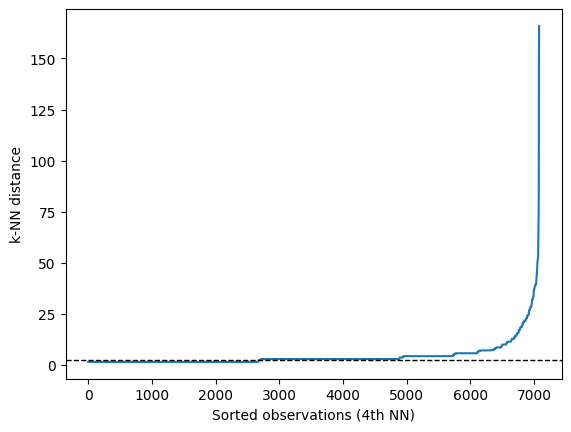

In [176]:
import matplotlib.pyplot as plt
k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.axhline(y=2.5, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [177]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=22, min_samples=100).fit(uns)
clusters.labels_
set(clusters.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6}

In [178]:
uns_copy = uns_copy.dropna()
uns_copy['cluster'] = clusters.labels_

In [183]:
uns_copy[uns_copy['cluster'] == 6]

,Relationship,full_community_id_src,name_src,Ar_trg,AtomicNumber_trg,Density_trg,MeltingPoint_trg,Symbol_trg,full_community_id_trg,name_trg,cluster
6371,IS_COMPOSED_OF,1783,C73500,54.938044,25.0,7.26,1246,Mn,330,MANGANESE,6
6372,IS_COMPOSED_OF,1783,C73500,63.546000,29.0,8.96,1085,Cu,319,COPPER,6
6374,IS_COMPOSED_OF,1783,C73500,55.845000,26.0,7.874,1538,Fe,321,IRON,6
6376,IS_COMPOSED_OF,1783,C73500,58.693400,28.0,8.902,1455,Ni,327,NICKEL,6
6377,IS_COMPOSED_OF,1783,C73500,58.693400,28.0,8.902,1455,Ni,327,NICKEL,6
...,...,...,...,...,...,...,...,...,...,...,...
6756,IS_COMPOSED_OF,1829,C79900,65.380000,30.0,7.13,419.5,Zn,328,ZINC,6
6758,IS_COMPOSED_OF,1829,C79900,58.693400,28.0,8.902,1455,Ni,327,NICKEL,6
6759,IS_COMPOSED_OF,1829,C79900,55.845000,26.0,7.874,1538,Fe,321,IRON,6
6760,IS_COMPOSED_OF,1829,C79900,58.693400,28.0,8.902,1455,Ni,327,NICKEL,6


In [185]:
uns

,Relationship,full_community_id_src,name_src,Ar_trg,AtomicNumber_trg,Density_trg,MeltingPoint_trg,Symbol_trg,full_community_id_trg,name_trg,cluster
0,0,712,645,207.2000,82.0,6,17,21,329,12,1
1,0,712,645,118.7100,50.0,10,15,26,326,23,1
2,0,712,645,63.5460,29.0,18,1,11,319,10,1
3,0,712,645,65.3800,30.0,13,19,30,328,25,1
4,0,712,645,65.3800,30.0,13,19,30,328,25,1
...,...,...,...,...,...,...,...,...,...,...,...
7113,0,1961,32,63.5460,29.0,18,1,11,319,10,5
7114,0,1961,32,107.8682,47.0,5,26,0,429,21,5
7115,0,1962,46,63.5460,29.0,18,1,11,319,10,5
7116,0,1963,47,63.5460,29.0,18,1,11,319,10,5
